In [1]:
import pandas as pd
import nltk
import re
# import csv
import matplotlib.pyplot as plt 
import seaborn as sns
# import sqlalchemy
from sqlalchemy import create_engine
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline
pd.set_option('display.max_colwidth', 300)


In [2]:
# meta = pd.read_csv("netflix_titles.csv")
rds_connection_string = f"roo2:123456@netflix.cy8gt7mz64dd.us-east-2.rds.amazonaws.com:5432/postgres"
engine = create_engine(f'postgresql://{rds_connection_string}')
meta = pd.read_sql_query('''SELECT t.title, t.rating, t.description, og.omdb_genre\
                        FROM public."Title" t\
                        LEFT JOIN public."OMDB_title_genre" ot\
                        ON t.show_id = ot.show_id\
                        LEFT JOIN public."OMDB_genre" og\
                        ON ot.omdb_genre_no = og.omdb_genre_no
                        WHERE og.omdb_genre is not null''', engine)
meta.head()

,title,rating,description,omdb_genre
0,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.",Animation
1,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.",Adventure
2,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.",Comedy
3,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.",Family
4,Jandino: Whatever it Takes,TV-MA,"Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of ""Sex on Fire"" in his comedy show.",Comedy


In [3]:
metas = meta.groupby('title').agg(lambda x: ','.join(set(x))).reset_index()
metas.head()

,title,description,omdb_genre
0,'89,"Mixing old footage with interviews, this is the story of Arsenal's improbable win versus Liverpool in the final moments of the 1989 championship game.",Drama
1,(T)ERROR,This real-life look at FBI counterterrorism operations features access to both sides of a sting: the government informant and the radicalized target.,Documentary
2,1 Chance 2 Dance,"When an aspiring dancer is uprooted during her senior year of high school, she finds herself torn between two boys – and with one shot at her dream.","Drama,Family"
3,1 Mile to You,"After escaping the bus accident that killed his girlfriend, a high school student channels his grief into running, with the help of a new coach.","Romance,Sport,Drama"
4,10 Days in Sun City,"After his girlfriend wins the Miss Nigeria pageant, a young man faces unexpected competition of his own when he joins her on a campaign in South Africa.","Comedy,Romance,Adventure"


In [5]:
movies = metas.rename(columns={"omdb_genre":"genre"})
# movies = movie.drop(columns=['type', 'director', 'cast','country','date_added', 'release_year','duration'])
# movies.genre.unique()

In [6]:
# split the genre on the , into a list
# movies_list = movies.assign(genre=movies.genre.str.split(',')).explode('genre')

movies["genre"] = movies["genre"].str.split('\s*,\s*')
# movies["genre"] = movies["genre"].str.split('\s*,\s*')
movies_list = movies
movies_list.head()

,title,description,genre
0,'89,"Mixing old footage with interviews, this is the story of Arsenal's improbable win versus Liverpool in the final moments of the 1989 championship game.",[Drama]
1,(T)ERROR,This real-life look at FBI counterterrorism operations features access to both sides of a sting: the government informant and the radicalized target.,[Documentary]
2,1 Chance 2 Dance,"When an aspiring dancer is uprooted during her senior year of high school, she finds herself torn between two boys – and with one shot at her dream.","[Family, Drama]"
3,1 Mile to You,"After escaping the bus accident that killed his girlfriend, a high school student channels his grief into running, with the help of a new coach.","[Sport, Romance, Drama]"
4,10 Days in Sun City,"After his girlfriend wins the Miss Nigeria pageant, a young man faces unexpected competition of his own when he joins her on a campaign in South Africa.","[Comedy, Adventure, Romance]"


In [7]:
# movies_list['genre'].nunique()
# genre_df = pd.DataFrame(movies_list.genre.unique())
genre_df = pd.DataFrame(movies_list['genre'].value_counts())
genre_df.reset_index()
genre_df

movies_list["genre"].explode().nunique()

28

In [8]:
# grouped = movies_list.groupby('genre')


In [9]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text


movies_list['clean_description'] = movies_list['description'].apply(lambda x: clean_text(x))
movies_list.head()

,title,description,genre,clean_description
0,'89,"Mixing old footage with interviews, this is the story of Arsenal's improbable win versus Liverpool in the final moments of the 1989 championship game.",[Drama],mixing old footage with interviews this is the story of arsenals improbable win versus liverpool in the final moments of the championship game
1,(T)ERROR,This real-life look at FBI counterterrorism operations features access to both sides of a sting: the government informant and the radicalized target.,[Documentary],this real life look at fbi counterterrorism operations features access to both sides of a sting the government informant and the radicalized target
2,1 Chance 2 Dance,"When an aspiring dancer is uprooted during her senior year of high school, she finds herself torn between two boys – and with one shot at her dream.","[Family, Drama]",when an aspiring dancer is uprooted during her senior year of high school she finds herself torn between two boys and with one shot at her dream
3,1 Mile to You,"After escaping the bus accident that killed his girlfriend, a high school student channels his grief into running, with the help of a new coach.","[Sport, Romance, Drama]",after escaping the bus accident that killed his girlfriend a high school student channels his grief into running with the help of a new coach
4,10 Days in Sun City,"After his girlfriend wins the Miss Nigeria pageant, a young man faces unexpected competition of his own when he joins her on a campaign in South Africa.","[Comedy, Adventure, Romance]",after his girlfriend wins the miss nigeria pageant a young man faces unexpected competition of his own when he joins her on a campaign in south africa


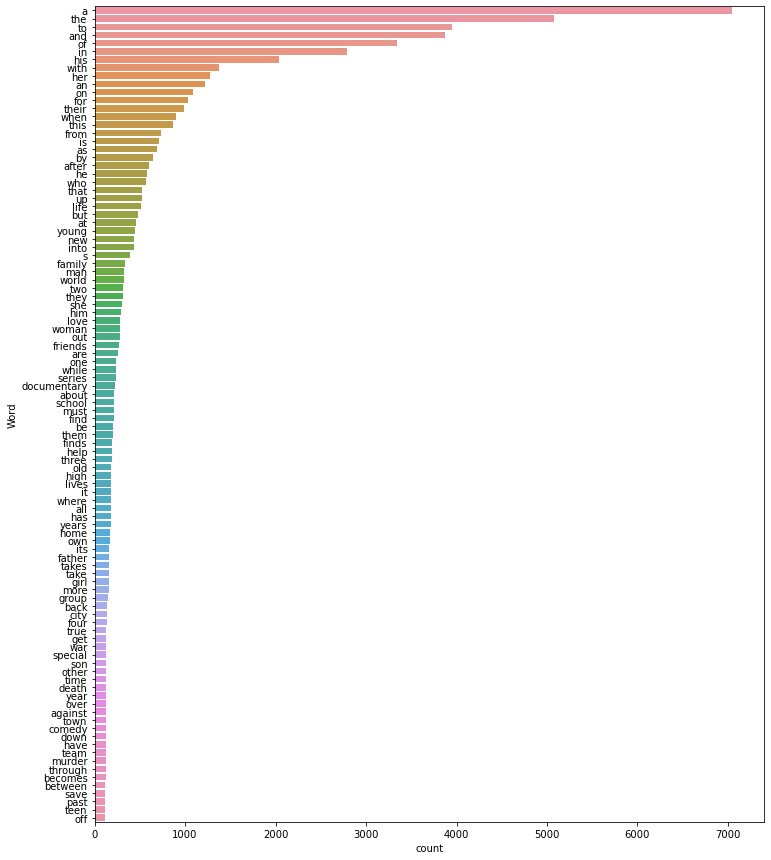

In [10]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_list['clean_description'], 100)

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_list['clean_descriptions'] = movies_list['clean_description'].apply(lambda x: remove_stopwords(x))

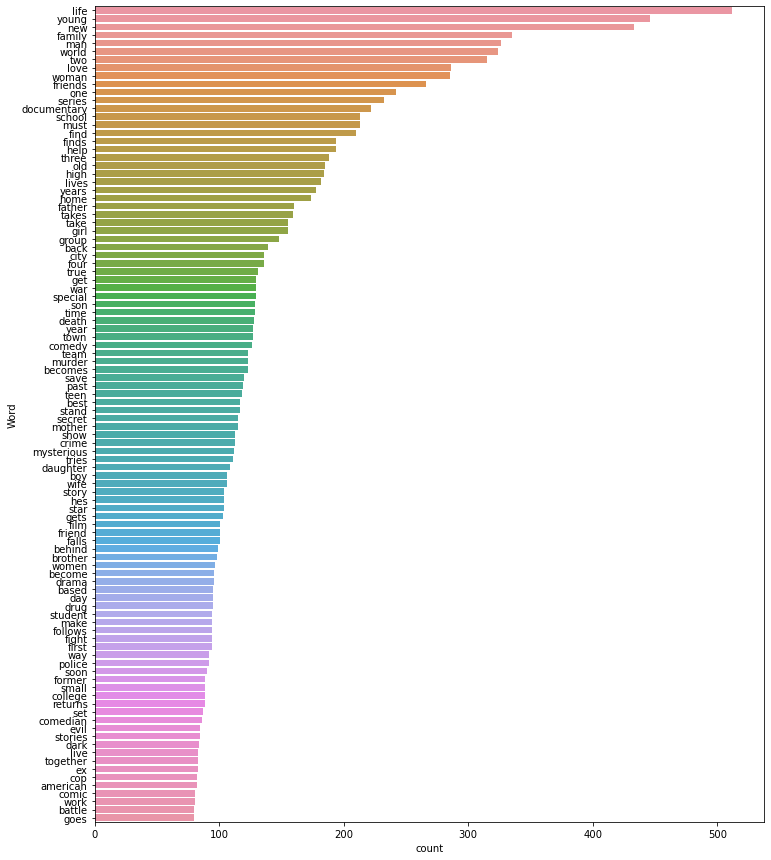

In [13]:
freq_words(movies_list['clean_descriptions'], 100)

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer


multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_list['genre'])

# transform target variable
y = multilabel_binarizer.transform(movies_list['genre'])

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.3, max_features=1500)

In [16]:
xtrain, xval, ytrain, yval = train_test_split(movies_list['clean_descriptions'], y, test_size=0.01, random_state=9)

In [17]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [18]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [19]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
# xtrain_tfidf


In [20]:
LogReg_pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('clf', OneVsRestClassifier(LogisticRegression()))
    
                           ])

# Training logistic regression model on train data


In [21]:
LogReg_pipeline.fit(xtrain, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.3, max_features=1500)),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [22]:
# fit model on train data
# clf.fit(xtrain_tfidf, ytrain)

In [23]:
# make predictions for validation set
y_pred = LogReg_pipeline.predict(xval)

In [24]:
y_pred[3]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [25]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Comedy',)

In [27]:
# evaluate performance
f1_score(yval, y_pred, average="micro")


0.4352941176470588

In [28]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
#     q_vec = tfidf_vectorizer.transform([q])
    q_pred = LogReg_pipeline.predict([q])
    return multilabel_binarizer.inverse_transform(q_pred)

In [32]:
for i in range(10): 
    k = xval.sample(1).index[0] 
    print("Movie: ", movies_list['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_list['genre'][k], "\n")

Movie:  EMI: Liya Hai To Chukana Padega 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Comedy', 'Crime', 'Drama'] 

Movie:  Tales of the City 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  Shuddhi 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'Crime', 'Drama'] 

Movie:  Compulsion 
Predicted genre:  [('Drama',)]
Actual genre:  ['Biography', 'History', 'Thriller', 'Crime', 'Drama'] 

Movie:  Tales of the City 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  The Only Mother To You All 
Predicted genre:  [('Comedy', 'Drama')]
Actual genre:  ['Comedy'] 

Movie:  Secret Obsession 
Predicted genre:  [('Thriller',)]
Actual genre:  ['Thriller'] 

Movie:  EMI: Liya Hai To Chukana Padega 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Comedy', 'Crime', 'Drama'] 

Movie:  Kulipari: Dream Walker 
Predicted genre:  [('Action',)]
Actual genre:  ['Fantasy', 'Action', 'Animation'] 

Movie:  Secret Obsession 
Predicted genre:  [('Thriller',)]
Actual genre:  ['Th

In [ ]:
test_desc = 'drug dealers'
print("Predicted genre: ", infer_tags(test_desc))

In [ ]:
# from joblib import dump, load
# dump(LogReg_pipeline, 'description_genre.joblib') 
import pickle
with open('description_genre.pkl', 'wb') as f:
    pickle.dump((multilabel_binarizer, LogReg_pipeline), f)


781179


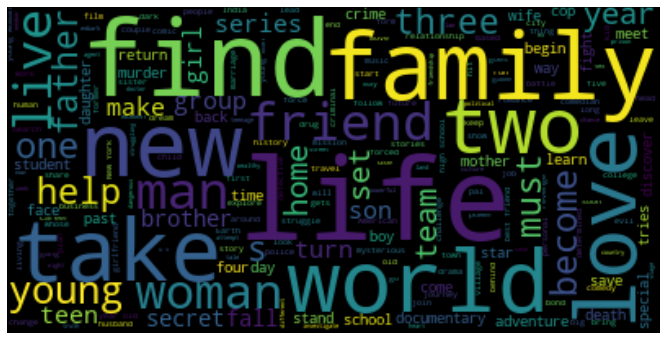

In [5]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in metas.description)
print(len(text))
wordcloud = WordCloud(background_color="black").generate(text)
plt.figure(figsize=(20,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()